<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/07-VariationalAutoEncoders/VAE_MNIST_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Fri Sep 25 09:49:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! git clone https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2

Cloning into 'TSAI-DeepVision-EVA4.0-Phase-2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 3563 (delta 0), reused 0 (delta 0), pack-reused 3558
Receiving objects: 100% (3563/3563), 136.97 MiB | 43.75 MiB/s, done.
Resolving deltas: 100% (215/215), done.


# RedCar - VAE

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torchvision.datasets as dset
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

from torchsummary import summary
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build the Models

In [5]:
class Encoder(nn.Module):
    """
    Creates the Encoder

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 3, ndf: int = 16, z_dim: int = 20):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 4, 4, 1, 0, bias=False)),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.mu = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)
        self.logvar = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)

    def forward(self, input):
        out = self.main(input)
        out = self.gap(out)
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu, logvar

In [124]:
class Decoder(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 3, ngf: int = 16, z_dim: int = 20):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [128]:
class RedCarVAE(nn.Module):
    def __init__(self, nc: int = 3, nf: int = 8, z_dims: int = 20):
        super(RedCarVAE, self).__init__()

        self.encoder = Encoder(nc, nf, z_dims)
        self.decoder = Decoder(nc, nf * 2, z_dims)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def reparam_like_train(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, input):
        mu, logvar = self.encoder(input)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar


In [157]:
redcarvae = RedCarVAE(nc=3, nf=32, z_dims=1024).to(device)

In [158]:
input = torch.randn(1, 3, 128, 128).to(device)
[x.shape for x in redcarvae(input)]

[torch.Size([1, 3, 128, 128]),
 torch.Size([1, 1024, 1, 1]),
 torch.Size([1, 1024, 1, 1])]

In [159]:
summary(redcarvae, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
         LeakyReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,768
         LeakyReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          65,536
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]         131,072
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]         262,144
        LeakyReLU-10            [-1, 128, 4, 4]               0
           Conv2d-11            [-1, 128, 1, 1]         262,144
        LeakyReLU-12            [-1, 128, 1, 1]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Conv2d-14           [-1, 102

In [160]:
def vae_gaussian_kl_loss(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    return KLD.mean()

def reconstruction_loss(x_reconstructed, x):
    return torch.sum(F.mse_loss(x_reconstructed, x, reduction='none'), dim=(1, 2, 3)).mean()

def kl_divergence_loss(mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    recon_loss = reconstruction_loss(recon_x, y_true)

    kld_loss = vae_gaussian_kl_loss(mu, logvar)

    return recon_loss + kld_loss



In [161]:
input = torch.randn(32, 3, 128, 128).to(device)
y_true = torch.randn(32, 3, 128, 128).to(device)
output = redcarvae(input)
loss = loss_function(output, y_true)
loss

tensor(67028.1953, device='cuda:0', grad_fn=<AddBackward0>)

## Dataset

In [134]:
dataroot = "/content/TSAI-DeepVision-EVA4.0-Phase-2/06-GenerativeAdversarialNetworks/car_images_100x100"
image_size = 128
batch_size = 256

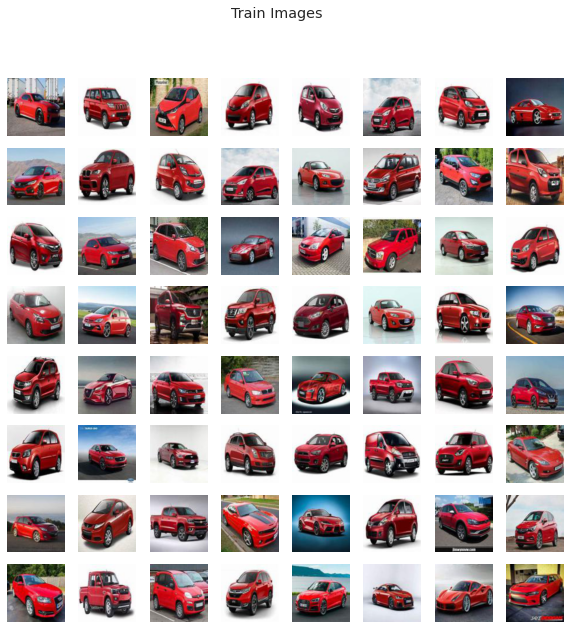

In [135]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                                                T.Resize((image_size, image_size)),
                                                T.ToTensor(),
                                                ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# Plot some training images
plt.ioff()
real_batch, _ = next(iter(dataloader))
fig = plt.figure(figsize=(10, 10))
plt.title("Training Images")
for idx, image in enumerate(real_batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
# plt.show()
fig.suptitle('Train Images')
plt.show()
# fig.tight_layout()
# fig.savefig('test.jpg')
# plt.close()

In [136]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                                                T.Resize((image_size, image_size)),
                                                T.ToTensor(),
                                                T.Normalize(mean=[0.570838093757629, 0.479552984237671, 0.491760671138763], std=[0.279659748077393, 0.309973508119583, 0.311098515987396]),
                                                ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [137]:
def save_images(data, title='', dest='test.jpg'):
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    # fetch the first 64 images only
    for idx, image in enumerate(data[:64]):
        plt.subplot(8, 8, idx+1)
        image.squeeze_(0)
        plt.imshow(image.cpu(), cmap='gray')
        plt.axis('off')
        plt.grid('off')
    fig.suptitle(title)
    fig.savefig(dest)
    plt.close()

## Train the Model

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [174]:
model = RedCarVAE(nc=3, nf=24, z_dims=2048)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [175]:
from tqdm.auto import tqdm

def train_epoch(model, optimizer):
    model.train()

    model = model.to(device)

    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        optimizer.zero_grad() # zero out the gradients

        output = model(data) # forward pass

        loss = loss_function(output, data) # compute the loss

        loss.backward() # backprop the loss

        train_loss += loss.item()

        optimizer.step() # update the optimizer
    
    return (train_loss / len(dataloader))

In [244]:
NUM_EPOCHS = 500
out_images = Path('vae_output')
out_images.mkdir(parents=True, exist_ok=True)
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    avg_loss = train_epoch(model, optimizer)

    if epoch % 20 == 0 or epoch == NUM_EPOCHS:
        print(f'=> Epoch: {epoch}\tAverage Loss: {avg_loss:.4f}\n')

=> Epoch: 20	Average Loss: 7564.0351

=> Epoch: 40	Average Loss: 7575.7485

=> Epoch: 60	Average Loss: 7554.7513

=> Epoch: 80	Average Loss: 7559.8476

=> Epoch: 100	Average Loss: 7554.3120

=> Epoch: 120	Average Loss: 7545.6054

=> Epoch: 140	Average Loss: 7557.5286

=> Epoch: 160	Average Loss: 7543.5812

=> Epoch: 180	Average Loss: 7536.0102

=> Epoch: 200	Average Loss: 7538.7070

=> Epoch: 220	Average Loss: 7530.6430

=> Epoch: 240	Average Loss: 7510.7571

=> Epoch: 260	Average Loss: 7550.8767

=> Epoch: 280	Average Loss: 7534.7463

=> Epoch: 300	Average Loss: 7503.9858

=> Epoch: 320	Average Loss: 7527.3315

=> Epoch: 340	Average Loss: 7544.4096

=> Epoch: 360	Average Loss: 7535.3048

=> Epoch: 380	Average Loss: 7509.4783

=> Epoch: 400	Average Loss: 7507.6455

=> Epoch: 420	Average Loss: 7495.9643

=> Epoch: 440	Average Loss: 7513.9233

=> Epoch: 460	Average Loss: 7498.1963

=> Epoch: 480	Average Loss: 7519.7244

=> Epoch: 500	Average Loss: 7486.3311




Let's try to see what the model outputs if we provide it with some random z vector

In [245]:
with torch.no_grad():
    model.eval()
    sample = torch.randn(64, 2048, 1, 1).to(device)
    output = model.decoder(sample)

In [204]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=[0.570838093757629, 0.479552984237671, 0.491760671138763], std=[0.279659748077393, 0.309973508119583, 0.311098515987396])

In [246]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

Trying out with random data

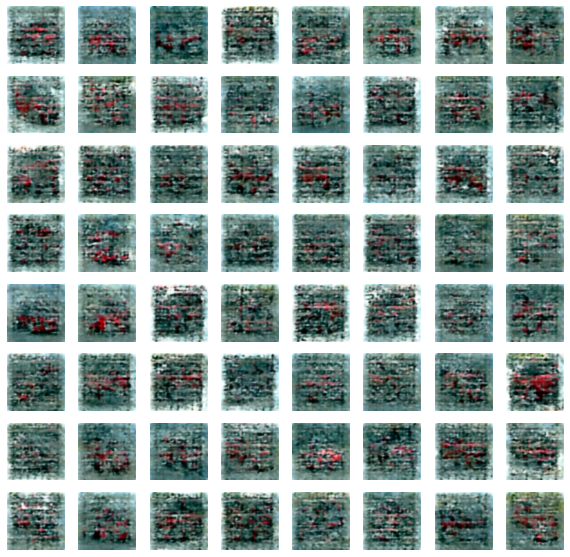

In [247]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(output[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    norm_tensor(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')

plt.show()

## Lets see how the model reconstructs input images

In [248]:
batch, _ = next(iter(dataloader))
with torch.no_grad():
    batch = batch.to(device)

    out, mu, logvar = model(batch)

Traceback (most recent call last):


In [249]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    image = unorm(image)
    # norm_tensor(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
predicted = np.array(fig.canvas.renderer.buffer_rgba())

In [250]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    image = unorm(image)
    # norm_tensor(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
real = np.array(fig.canvas.renderer.buffer_rgba())

Lets see how well it reconstructs images, from only 2048 values ! and a 50MB model

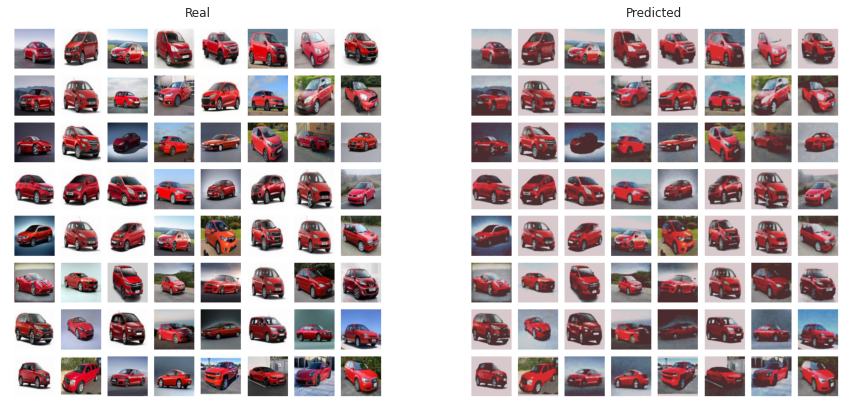

In [252]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(real)
plt.title('Real')
plt.grid('off')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title('Predicted')
plt.grid('off')
plt.axis('off')

plt.show()

Playing with the z vector of the reconstructed images

In [266]:
batch.shape

torch.Size([256, 3, 128, 128])

In [267]:
batch, _ = next(iter(dataloader))
with torch.no_grad():
    batch = batch.to(device)

    out, mu, logvar = model(batch)

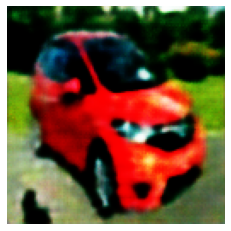

In [276]:
image = out[13]
norm_tensor(image)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.grid('off')
plt.show()

In [277]:
torch.save(model, 'redcar_vae_128x128.pt')

In [278]:
traced_model = torch.jit.trace(model.to('cpu'), torch.randn(1, 3, 128, 128))

In [279]:
traced_model.save('redcar_vae_128x128.traced.pt')